In [1]:
from tqdm import tqdm 
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from utils.base import eval_accuracy
from utils.base import get_correct_predictions_subset
from utils.data import create_butterfly_dataset
from utils.data import create_imagenet_dataset
from model.butterfly_classifier import DenseNet121
from algo.attacker import adversarial_generator
from torch.utils.data import DataLoader
import torch.nn.functional as F

from algo.attacker import PIA_adversarial_generator
from algo.defender import PartialInfo
from tqdm import trange
from utils.base import quick_predict

In [2]:
trainset, testset, normal_mapping, reverse_mapping, sample_img_dataset = create_butterfly_dataset()
assert len(trainset) == 12594, 'Size of train set not match'
assert len(testset) == 500, 'Size of test set not match'

In [3]:
model = DenseNet121(num_classes=len(normal_mapping)).to('cuda')
model.load_state_dict(torch.load('./model/states/butterfly_classifier.pth'))
model.eval()

DenseNet121(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32, kerne

In [5]:
# parameters definition
batch_size = 32
query_limit = 30000 # max attack limit 
LO_query_limit = 3000000 # max attack limit 
search_var = 1e-3 # amount to perturb the input image
sample_num = 50 # 2*sample_num for estimating gradient
bound = 0.1 # the l-infinity distance between the adversarial example and the input image
# partial information paramters + lebel-only parameters
epsilon = 0.5 # initial searching range from the target image
delta = 0.01 # rate to decrease epsilon
eta_max = 0.02 # maximum learning rate
eta_min = 0.01 # minimum learning rate
k = 5 # information access
# label-only parameter
mu = 0.001 # radius for sampling ball
m = 50 # 2*number of sample for proxy score
#correct_subset_loader = DataLoader(correct_subset, batch_size = batch_size, shuffle = False)
#correct_subset_loader = DataLoader(correct_subset, batch_size = 2, shuffle = False)
lr = 0.01

In [39]:
def plot_result(original_img, adv_img, model):
    image_np1 = adv_img.squeeze().cpu().detach().numpy()
    image_np2 = original_img.squeeze().cpu().detach().numpy()
    import numpy as np
    import matplotlib.pyplot as plt
    # If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
    if image_np1.ndim == 3:
        # Transpose the image for plotting
        image_np1 = image_np1.transpose(1, 2, 0)

    # If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
    if image_np1.max() <= 1.0:
        image_np1 = (image_np1 * 255).astype(np.uint8)
    # If the image has more than one channel, transpose the dimensions from [C, H, W] to [H, W, C]
    if image_np2.ndim == 3:
        # Transpose the image for plotting
        image_np2 = image_np2.transpose(1, 2, 0)

    # If the image is in the range [0, 1], ensure it's scaled to [0, 255] if needed
    if image_np2.max() <= 1.0:
        image_np2 = (image_np2 * 255).astype(np.uint8)
    
    #Find Label
    original_class = torch.argmax(model(original_img.unsqueeze(0).to('cuda')),dim = 1).item()
    original_label = reverse_mapping[original_class]
    adv_class = torch.argmax(model(adv_image.to('cuda')),dim = 1).item()
    adv_label = reverse_mapping[adv_class]
    
    
    # Plot the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np1)
    plt.title('Adversarial Image_processing')
    plt.axis('off')
    plt.text(0.5, -0.05, adv_label, ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.subplot(1, 2, 2)
    plt.imshow(image_np2)
    plt.title('Original Image')
    plt.axis('off')
    plt.text(0.5, -0.05, original_label, ha='center', va='center', transform=plt.gca().transAxes)

In [16]:
adv_image, _ = adversarial_generator(model,[24], testset[0][0].unsqueeze(0).to('cuda'), search_var, sample_num,bound, lr, query_limit)

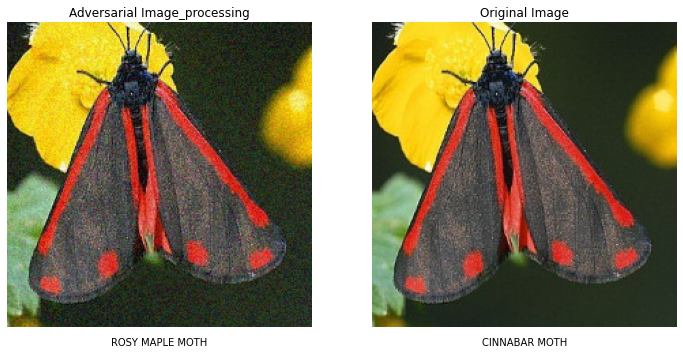

In [40]:
#Query Limited
plot_result(testset[0][0], adv_image, model)

In [42]:
adv_image,_ = PIA_adversarial_generator(model, testset[0][0].unsqueeze(0).to('cuda'), sample_img_dataset,
                                                                      epsilon, delta, search_var,
                                                                      sample_num, eta_max, eta_min,
                                                                      bound, k, query_limit, label_only = False)

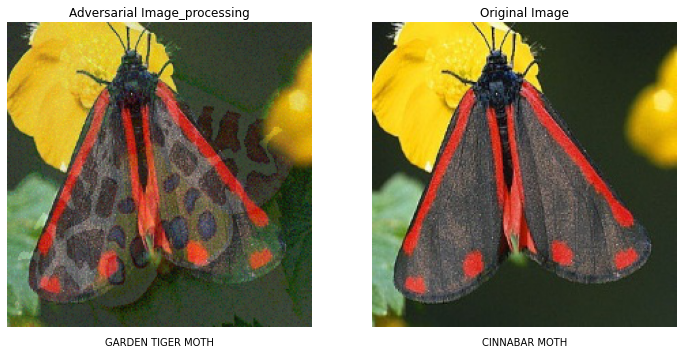

In [46]:
#PIA
plot_result(testset[0][0], adv_image, model)

In [52]:
#label only
accuracy, correct_subset = get_correct_predictions_subset(model, testset, batch_size=100)

adv_imgs = torch.load('LO_adv_img.pt')
adv_img = adv_imgs[0]
images = correct_subset[0][0]
plot_result(images, adv_img, model)